# 通し課題 Day2　　Kickstarter Projects

【目的】あるクラウドファンディングが成功するかどうか事前に予測するためのモデルを作成する

【データ】CSVファイルの読み込み

## [進捗状況] << 2020.10.12 現在 >>
- Day1で作成したロジスティック回帰モデルの精度を向上させるため、標準化、正則化を実施
- Day1で採用した説明変数は、goal, category_Apparel であったが、それぞれ採用する説明変数を変更する。
- goalに関しては、単位統一された usd_goal_real を採用する。
- category_Apparel は、適当にピックアップした説明変数なので、メインカテゴリのうち下記条件にてカテゴリの説明変数を採用。

　**メインカテゴリのうち、state = successful が最頻値となっていて、件数が最も多い Music を説明変数として採用。**

- クラウドファンディングの期間は成功するかどうかに影響すると考えたので説明変数として採用 (deadline(締切日)とlaunched(開始日時)を日数計算し、period(期間)を定義)
- 説明変数、目的変数は下記のとおりである。

　**(説明変数) usd_goal_real, main_category_Music, period**

　**(目的変数) state**

- 標準化と正則化を行う前後での混同行列と分類評価を作成。
- 標準化と正則化を行うことでPrecisionの値が改善されたので、予測モデルとしての精度が高くなったと考えられる。


## [今後の課題]
- より精度の高いモデルを作るために必要な要素が何なのか検討する必要がある。
- 正則化項のλを決定するために、グリッドサーチによるハイパーパラメータの最適化を図ったがうまくコーディングできなかったので改善したい。

## ライブラリのインポート

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd  # Pandas
import numpy as np   # Numpy
import seaborn as sns # Seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier # 確率的勾配法
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## CSVファイル入出力関連

In [2]:
# CSVファイルの読み込み
# データフレームの作成
kick_st = pd.read_csv('ks-projects-201801.csv')

# CSVファイル読み込みの確認
kick_st

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [3]:
# state の successful or failed の行だけ抽出する
kick_tmp = kick_st.copy()
kick_tmp = kick_tmp[kick_tmp['state'].isin(['failed','successful'])]

#kick_tmp の内容確認
kick_tmp

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2500.0,2013-09-09 18:19:37,0.00,failed,0,CA,0.00,0.00,2406.39
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.00,successful,100,US,12700.00,12700.00,12500.00
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02,5000.0,2014-09-02 17:11:50,0.00,failed,0,US,0.00,0.00,5000.00


In [4]:
# 条件を絞ったデータフレームをCSVファイルへ書き出し
kick_tmp.to_csv("ks-projects-201801-select.csv")

In [5]:
# state が successful の時 True, failed の時 False とする
kick_tmp2 = kick_tmp.replace(["successful","failed"],[True, False])
kick_tmp2

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,False,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,False,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,False,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,False,1,US,1.00,1.00,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,True,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,True,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,False,40,US,453.00,453.00,25000.00
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2500.0,2013-09-09 18:19:37,0.00,False,0,CA,0.00,0.00,2406.39
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.00,True,100,US,12700.00,12700.00,12500.00
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02,5000.0,2014-09-02 17:11:50,0.00,False,0,US,0.00,0.00,5000.00


## 説明変数の検証

### category について
categoryの件数とstateの平均をグラフ化する

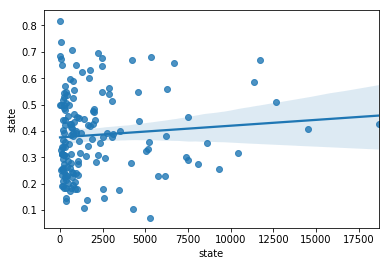

In [6]:
# カテゴリの件数とstateの平均のグラフ
cntctg = kick_tmp2.groupby(['category']).state.count()  # 件数
meanctg = kick_tmp2.groupby(['category']).state.mean()  # 平均
sns.regplot(cntctg, meanctg)
# カテゴリによってわかるわけではなさそうである

【考察】件数が多いので成功しやすいわけではなく、カテゴリによると考えられる。

### main_category について
categoryだと詳細すぎるため、main_categoryに注目。

main_category の基本統計量を算出し、successfulが最頻値となるカテゴリは成功しやすいと考える。

In [7]:
# メインカテゴリの state の基本統計量を算出
kick_tmp2.groupby(['main_category']).state.describe()

,count,unique,top,freq
main_category,,,,
Art,25641,2,False,14131
Comics,9878,2,True,5842
Crafts,7818,2,False,5703
Dance,3573,2,True,2338
Design,25364,2,False,14814
Fashion,19775,2,False,14182
Film & Video,56527,2,False,32904
Food,22054,2,False,15969
Games,28521,2,False,16003


【考察】今回は件数が最も多く、Trueが最頻値となっている Music に注目する。

また、件数とstateの平均をグラフ化する。

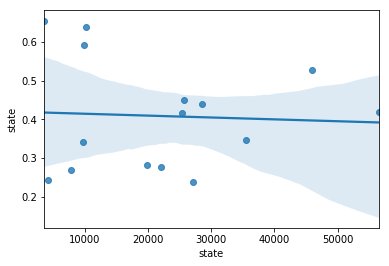

In [8]:
# メインカテゴリの件数とstateの平均のグラフ
cntmctg = kick_tmp2.groupby(['main_category']).state.count()  # 件数
meanmctg = kick_tmp2.groupby(['main_category']).state.mean()  # 平均
sns.regplot(cntmctg, meanmctg)

### usd_goal_real について
目標金額によって成功しやすいかどうかを検討する。

usd_goal_realがUSドルに単位統一されたものなので、この列を採用する。

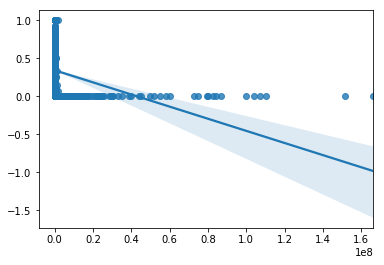

In [9]:
# usd_goal_realの平均とstateのグラフ
meanugr = kick_tmp2.groupby(['usd_goal_real']).state.mean()  # 平均
sns.regplot(meanugr.index.array, meanugr.values)

【考察】一定の金額を超すと失敗しやすい傾向にある

### deadlineについて
期間が長くなると、成功しやすさに影響するのか検討する。

deadline(締切日)とlaunched(開始日時)を日数計算し、period(期間)を定義し平均を求める。

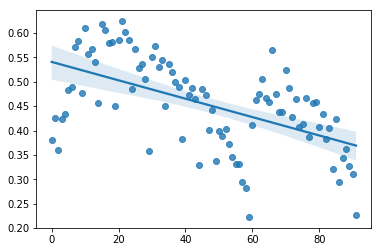

In [10]:
# deadline(締切日)とlaunched(開始日時)を timedate 型に変換
kick_tmp2['deadline'] = pd.to_datetime(kick_tmp2['deadline'], format='%Y-%m-%d %H:%M:%S')
kick_tmp2['launched'] = pd.to_datetime(kick_tmp2['launched'], format='%Y-%m-%d %H:%M:%S')

# クラウドファンディングの期間（日数）を計算
kick_tmp2['period']=(kick_tmp2['deadline'] - kick_tmp2['launched']).dt.days

# periodの平均とstateのグラフ
meanprd = kick_tmp2.groupby(['period']).state.mean()  # 平均
sns.regplot(meanprd.index.array, meanprd.values)

【考察】期間が長くなると失敗しやすい傾向にある。

### 欠損値の対応

In [11]:
# 欠損値の確認
kick_tmp2.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
period                0
dtype: int64

欠損値は少ないので、dropすることとする。

In [12]:
# 欠損値のdrop
kick_tmp2 = kick_tmp2.dropna()

### main_category をダミー変数に置換する

In [13]:
# ダミー変数に置換する
kick_tmp2 = pd.get_dummies(kick_tmp2, columns=['main_category'])

kick_tmp2

,ID,name,category,currency,deadline,goal,launched,pledged,state,backers,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,False,0,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,False,15,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,False,3,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,False,1,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,True,224,...,0,0,1,0,0,0,0,0,0,0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,True,16,...,0,0,1,0,0,0,0,0,0,0
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,False,40,...,0,0,1,0,0,0,0,0,0,0
10,100004721,Of Jesus and Madmen,Nonfiction,CAD,2013-10-09,2500.0,2013-09-09 18:19:37,0.00,False,0,...,0,0,0,0,0,0,0,1,0,0
11,100005484,Lisa Lim New CD!,Indie Rock,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.00,True,100,...,0,0,0,0,0,1,0,0,0,0
12,1000055792,The Cottage Market,Crafts,USD,2014-10-02,5000.0,2014-09-02 17:11:50,0.00,False,0,...,0,0,0,0,0,0,0,0,0,0


## 学習
- 説明変数X：usd_goal_real, main_category_Music, period
- 目的変数y：state 

In [14]:
# ロジスティック回帰
# X：説明変数 (usd_goal_real, main_category_Music, period)  y：目的変数 (state)
y = kick_tmp2['state'].values
X = kick_tmp2[['usd_goal_real', 'main_category_Music', 'period']].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = 4224.005, w1 = -98.986, w2 = 1325.430, w3 = 56640.660


In [15]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -16.754
正答率 = 51.492%


## クロス集計

**混同行列**

In [16]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,53929,143682
正解 = successful,17104,116747


**Precision, Recall, F1**

In [17]:
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1を表示
print('Precision = {:.3f}%'.format(100 * precision[1]))
print('Recall = {:.3f}%'.format(100 * recall[1]))
print('F1 = {:.3f}%'.format(100 * f1_score[1]))

Precision = 44.829%
Recall = 87.222%
F1 = 59.220%


# 汎化誤差の検証
### ホールドアウト法
データ数は多いと判断されるため、汎化誤差の検証はホールドアウト法を採用する。

### 学習用データ(80%)　テストデータ(20%) の場合

In [18]:
# ホールドアウト法を用いて検証する
test_size = 0.2        # 全データのうち、何%をテストデータにするか（20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # テストデータはランダム選択

- X_train：学習データ用の説明変数
- X_test ：テストデータ用の説明変数
- y_train：学習データ用の目的変数
- y_test ：テストデータ用の目的変数

**学習データに対する予測**

In [19]:
# 学習用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 対数尤度を表示
print('対数尤度 [Train] = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率 [Train] = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

対数尤度 [Train] = -16.880
正答率 [Train] = 51.129%


**テストデータに対する予測**

In [20]:
# テスト用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
regr.fit(X_test, y_test)

# テスト用データに対する予測を実行
y_pred_test = regr.predict(X_test)

# 対数尤度を表示
print('対数尤度 [Test] = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率 [Test] = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

対数尤度 [Test] = -16.691
正答率 [Test] = 51.677%


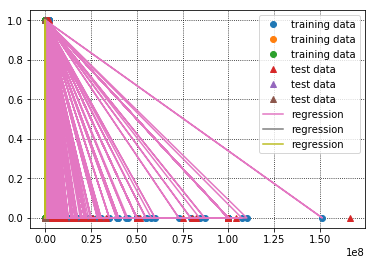

In [21]:
# グラフに重ねて表示する
plt.plot(X_train, y_train, 'o', label='training data')
plt.plot(X_test, y_test, '^', label='test data')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(X_train, y_pred_train, label='regression')
plt.legend(loc='best')
plt.show()

【考察】訓練誤差と汎化誤差における差はあまりないが、対数尤度をもっと最大化できるように最適化したい。このモデルでは、アンダーフィッティングしている。

### 学習用データを調整する
アンダーフィッティングの原因として、学習用データ数が多すぎる場合が考えられる。

念の為、学習用データ数を変更してホールドアウト法を検証する。

### 学習用データ(70%)　テストデータ(30%) の場合

In [22]:
# ホールドアウト法を用いて検証する
test_size = 0.3        # 全データのうち、何%をテストデータにするか（30%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # テストデータはランダム選択

In [23]:
# 学習用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 対数尤度を表示
print('対数尤度 [Train] = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率 [Train] = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

対数尤度 [Train] = -16.006
正答率 [Train] = 53.658%


In [24]:
# テスト用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
regr.fit(X_test, y_test)

# テスト用データに対する予測を実行
y_pred_test = regr.predict(X_test)

# 対数尤度を表示
print('対数尤度 [Test] = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率 [Test] = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

対数尤度 [Test] = -13.813
正答率 [Test] = 60.008%


【考察】学習用データを減らすと汎化誤差との差が大きくなった。このモデルでは、学習用データ数の調整だけではなく正則化等の処理が必要と考える。

## 正則化
このモデルのアンダーフィッティングを解消するため、正則化する。

テストデータは20%(学習誤差と汎化誤差の差が小さいため)、正則化項のλは小さくする。

In [25]:
# ホールドアウト法を用いて検証する
test_size = 0.2        # 全データのうち、何%をテストデータにするか（20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # テストデータはランダム選択

### ハイパーパラメータの最適化
グリッドサーチにより、最適な正則化項λの値を決定する。

In [26]:
# グリッドサーチによるハイパーパラメータの最適化
param_grid = {'alpha' : [0.0001, 0.001, 0.01]}
model = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_, grid_search.best_score_)

C:\Users\keiryo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\keiryo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\keiryo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\keiryo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

正則化項λの値は、**0.001**に設定する。

※グリッドサーチから算出したかったが、うまくコーディングできなかったので手動検索で決定した。

### 学習用データに対する予測 (λ＝0.001)

In [27]:
# 学習用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.001)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 対数尤度を表示
print('対数尤度 [Train] = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率 [Train] = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

対数尤度 [Train] = -14.919
正答率 [Train] = 56.806%


### テスト用データに対する予測 (λ＝0.001)

In [28]:
# テスト用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.001)
regr.fit(X_test, y_test)

# テスト用データに対する予測を実行
y_pred_test = regr.predict(X_test)

# 対数尤度を表示
print('対数尤度 [Test] = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率 [Test] = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

対数尤度 [Test] = -16.070
正答率 [Test] = 53.475%


正答率が学習誤差、汎化誤差ともに向上した。精度が高くなったといえる。

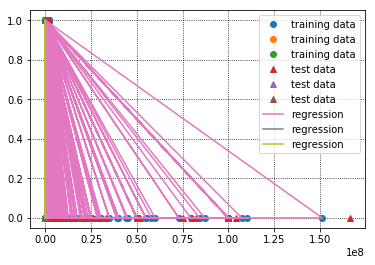

In [29]:
# グラフに重ねて表示する
plt.plot(X_train, y_train, 'o', label='training data')
plt.plot(X_test, y_test, '^', label='test data')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(X_train, y_pred_train, label='regression')
plt.legend(loc='best')
plt.show()

スケールが合っていないのか、グラフが見にくいため標準化する。

## データを標準化する
説明変数のスケールを標準化する。

In [30]:
# 説明変数(学習データ)の標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X)

# データの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X_train_stand, y, test_size=test_size, random_state=1234) # テストデータはランダム選択

### 学習用データに対する予測 (λ＝0.001)

In [31]:
# 学習用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.001)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 対数尤度を表示
print('対数尤度 [Train] = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率 [Train] = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

対数尤度 [Train] = -13.427
正答率 [Train] = 61.125%


### テスト用データに対する予測 (λ＝0.001)

In [32]:
# テスト用データを使ってロジスティック回帰モデルを学習
regr = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.001)
regr.fit(X_test, y_test)

# テスト用データに対する予測を実行
y_pred_test = regr.predict(X_test)

# 対数尤度を表示
print('対数尤度 [Test] = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率 [Test] = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

対数尤度 [Test] = -13.208
正答率 [Test] = 61.759%


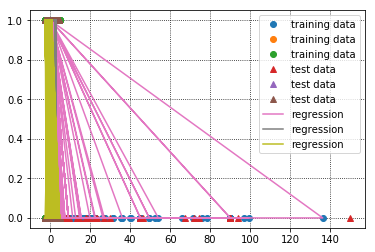

In [33]:
# グラフに重ねて表示する
plt.plot(X_train, y_train, 'o', label='training data')
plt.plot(X_test, y_test, '^', label='test data')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(X_train, y_pred_train, label='regression')
plt.legend(loc='best')
plt.show()

【考察】データのスケールの統一が行えただけでなく、対数尤度の値も改善した。極端な外れ値も存在したと考えられる。

よって、本データに関しては標準化は必要な前処理であったと考えられる。

## クロス集計(標準化, 正則化後)

**混同行列**

In [34]:
# 予測値と正解のクロス集計
conf_mat2 = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat2

,予測 = failed,予測 = successful
正解 = failed,35230,4601
正解 = successful,20750,5712


**Precision, Recall, F1**

In [35]:
# Precision, Recall, F1-scoreを計算
precision2, recall2, f1_score2, _ = precision_recall_fscore_support(y_test, y_pred_test)

# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1を表示
print('Precision = {:.3f}%'.format(100 * precision2[1]))
print('Recall = {:.3f}%'.format(100 * recall2[1]))
print('F1 = {:.3f}%'.format(100 * f1_score2[1]))

Precision = 55.386%
Recall = 21.586%
F1 = 31.065%


Precisionの値が、44.829%から55.386%に改善された。

### 標準化、正則化を行うことで、Day1のモデルと比較して予測モデルとしての精度は向上したと考えられる。